In [21]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

import nibabel as nib
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader

In [4]:
%load_ext autoreload
%autoreload 2
from model.uunet_3d import UNet
from processing.dataloader import load_train_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA
### Input _ [batch * channel(# of channels of each image) * depth(# of frames) * height * width].

# Train

In [4]:
device = torch.device("cpu")
print(device)

cpu


# DATA

In [8]:
X = load_train_images('data_processed/x_images/', shape=(32,32,32))
Y = load_train_images('data_processed/y_images/', shape=(32,32,32))
print(type(X),X.shape)
print(type(Y),Y.shape)

<class 'numpy.ndarray'> (219, 32, 32, 32)
<class 'numpy.ndarray'> (219, 32, 32, 32)


Classes in label: [0. 1. 2.]


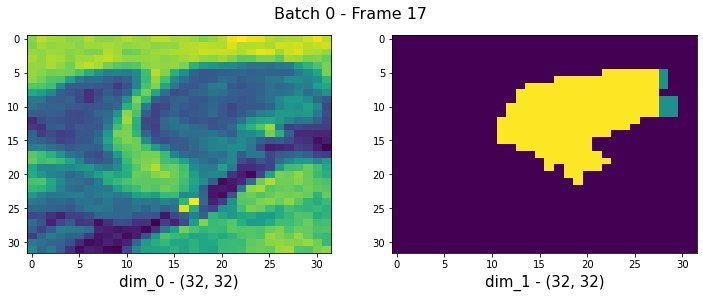

In [7]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X[batch_image,:,:,image_index],Y[batch_image,:,:,image_index]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)

print('Classes in label:',np.unique(Y[batch_image,:,:,image_index]))

In [8]:
Y_one = np.where(Y==2.,1.,Y)

In [9]:
Y_one.shape

(219, 32, 32, 32)

Classes in label: [0. 1.]


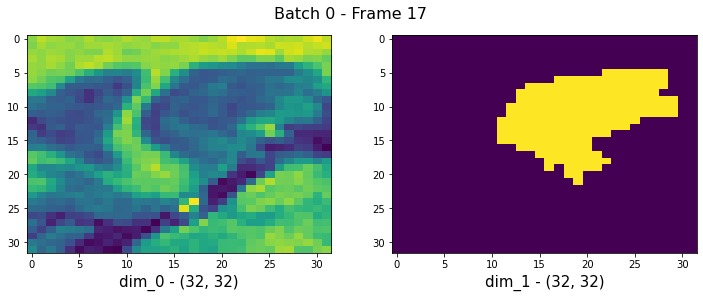

In [10]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X[batch_image,:,:,image_index],Y_one[batch_image,:,:,image_index]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)

print('Classes in label:',np.unique(Y_one[batch_image,:,:,image_index]))

In [11]:
Y = Y_one

In [12]:
X = X.astype('float32') / 255.0
X = torch.from_numpy(X)

#Y = Y.astype('float32') / 255.0
#Y = torch.from_numpy(Y)
Y = torch.from_numpy(Y_one)

Classes in label: [0. 1.]


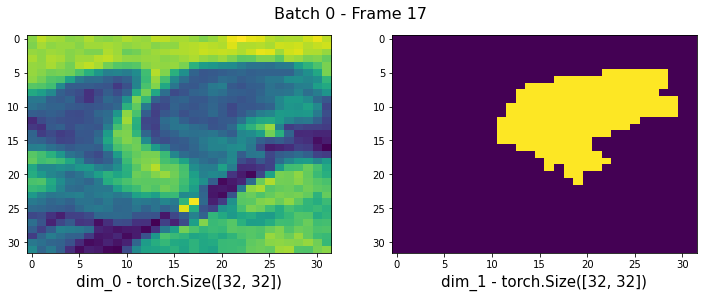

In [13]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X[batch_image,:,:,image_index],Y[batch_image,:,:,image_index]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)
print('Classes in label:',np.unique(Y[batch_image,:,:,image_index]))

In [14]:
X = X.permute(0, 3, 1, 2)
print('X',X.shape)
X = torch.unsqueeze(X, dim=1)
print('X',X.shape)
print('')
Y = Y.permute(0, 3, 1, 2)
print('Y',Y.shape)
Y = torch.unsqueeze(Y, dim=1)
print('Y',Y.shape)

X torch.Size([219, 32, 32, 32])
X torch.Size([219, 1, 32, 32, 32])

Y torch.Size([219, 32, 32, 32])
Y torch.Size([219, 1, 32, 32, 32])


Classes in label: [0. 1.]


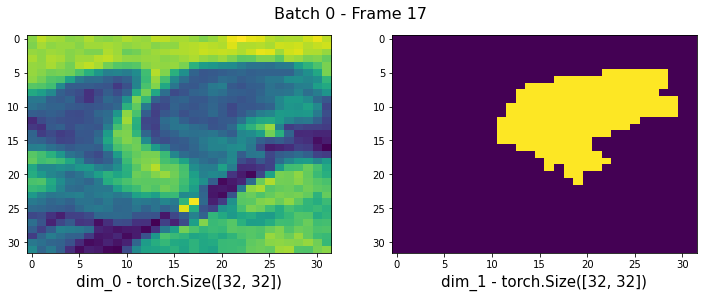

In [15]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X[batch_image,0,image_index,:,:],Y[batch_image,0,image_index,:,:]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)
print('Classes in label:',np.unique(Y[batch_image,:,image_index,:,:]))

In [16]:
BATCH_SIZE = 16

In [17]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(X, Y)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
print(len(train_loader))
for xb, yb in train_loader:
    print(xb.shape, yb.shape)

14
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32]) torch.Size([16, 1, 32, 32, 32])
torch.Size([11, 1, 32, 32, 32]) torch.Size([11, 1, 32, 32, 32])


In [19]:
n1 = 64
filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
filters

[64, 128, 256, 512, 1024]

In [20]:
EPOCHS = 5
LEARNING_RATE = 0.001

model = UNet(filters=filters)
#loss = nn.CrossEntropyLoss()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.to(device)
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        #print(y_pred[0])
        #print('y_pred', y_pred[0].shape)
        
        
        loss_calc = loss(y_pred[0], y_batch)#.type(torch.LongTensor))
        #print(loss_calc)

        
        loss_calc.backward()
        optimizer.step()
        
        epoch_loss += loss_calc.item()

        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

ValueError: Target size (torch.Size([16, 1, 32, 32, 32])) must be the same as input size (torch.Size([16, 2, 32, 32, 32]))

In [29]:
model.eval()
print('')

In [30]:
nii_file  = nib.load('data/hippo_train.nii.gz')
nii_data = nii_file.get_fdata()
print(type(nii_data))
print('Height, Width, N_images, Channels')
print(nii_data.shape)

<class 'numpy.ndarray'>
Height, Width, N_images, Channels
(32, 32, 32)


In [31]:
x = torch.from_numpy(nii_data)
print(x.shape)
print(x.dtype)

torch.Size([32, 32, 32])
torch.float64


In [32]:
x = x.permute(2, 0, 1)
print(x.shape)
print(x.dtype)

torch.Size([32, 32, 32])
torch.float64


In [33]:
x = torch.unsqueeze(x, dim=0)
print(x.shape)
print(x.dtype)

torch.Size([1, 32, 32, 32])
torch.float64


In [34]:
x = torch.unsqueeze(x, dim=0)
print(x.shape)
print(x.dtype)

torch.Size([1, 1, 32, 32, 32])
torch.float64


In [35]:
y_result = model(x.float())

In [36]:
print(len(y_result))
y_result[0].shape

1


torch.Size([1, 1, 32, 32, 32])

In [37]:
torch.save(y_result[0], 'prediction/my_pred_tensor.pth')